In [83]:
import numpy as np
import pickle
import scipy.ndimage
import matplotlib.pyplot as plt
import math
import fceulib
import networkx as nx
import nxpd
import sets
# TODO: UnionFind, probably via import

In [84]:
"""UnionFind.py

Union-find data structure. Based on Josiah Carlson's code,
http://aspn.activestate.com/ASPN/Cookbook/Python/Recipe/215912
with significant additional changes by D. Eppstein.
"""

class UnionFind:
    """Union-find data structure.

    Each unionFind instance X maintains a family of disjoint sets of
    hashable objects, supporting the following two methods:

    - X[item] returns a name for the set containing the given item.
      Each set is named by an arbitrarily-chosen one of its members; as
      long as the set remains unchanged it will keep the same name. If
      the item is not yet part of a set in X, a new singleton set is
      created for it.

    - X.union(item1, item2, ...) merges the sets containing each item
      into a single larger set.  If any item is not yet part of a set
      in X, it is added to X as one of the members of the merged set.
    """

    def __init__(self):
        """Create a new empty union-find structure."""
        self.weights = {}
        self.parents = {}

    def __getitem__(self, object):
        """Find and return the name of the set containing the object."""

        # check for previously unknown object
        if object not in self.parents:
            self.parents[object] = object
            self.weights[object] = 1
            return object

        # find path of objects leading to the root
        path = [object]
        root = self.parents[object]
        while root != path[-1]:
            path.append(root)
            root = self.parents[root]

        # compress the path and return
        for ancestor in path:
            self.parents[ancestor] = root
        return root
        
    def __iter__(self):
        """Iterate through all items ever found or unioned by this structure."""
        return iter(self.parents)

    def union(self, *objects):
        """Find the sets containing the objects and merge them all."""
        roots = [self[x] for x in objects]
        heaviest = max([(self.weights[r],r) for r in roots])[1]
        for r in roots:
            if r != heaviest:
                self.weights[heaviest] += self.weights[r]
                self.parents[r] = heaviest

In [85]:

input1,input2 = pickle.load(open('inputs.pkl'))

tile_collisions = pickle.load(open('tile_collisions.pkl'))
sprite_collisions = pickle.load(open('sprite_collisions.pkl'))

merged_trace, modes = pickle.load(open("merged_trace.pkl"))
print tile_collisions

{0: [(1, 0), (1, 0), (1, 6), (3, 0), (1, 0), (1, 4), (2, 0), (2, 0), (1, 6), (2, 0), (2, 0), (2, 4)], 1: [(1, 0), (1, 0), (1, 4), (3, 0), (2, 0), (1, 6), (2, 0), (2, 0), (2, 4)], 2: [(1, 0), (1, 0), (1, 4), (3, 0), (2, 0), (1, 6), (2, 0), (2, 0), (2, 4)], 3: [(1, 0), (1, 0), (1, 4), (3, 0), (1, 0), (1, 6), (2, 0), (2, 0), (1, 4), (2, 0), (2, 17), (2, 6)], 4: [(1, 0), (1, 0), (1, 6), (2, 0), (2, 0), (1, 4), (2, 0), (2, 17), (2, 6)], 5: [(1, 0), (1, 0), (1, 6), (3, 0), (2, 0), (1, 4), (2, 0), (2, 17), (2, 6)], 6: [(1, 0), (1, 0), (1, 6), (3, 0), (1, 0), (1, 4), (2, 0), (2, 17), (1, 6)], 7: [(1, 0), (1, 0), (1, 4), (2, 0), (2, 17), (1, 6), (2, 18), (2, 19), (2, 4)], 8: [(1, 0), (1, 0), (1, 4), (3, 0), (2, 17), (1, 6), (2, 18), (2, 19), (2, 4)], 9: [(1, 0), (1, 0), (1, 4), (3, 0), (1, 17), (1, 6), (2, 18), (2, 19), (1, 4)], 10: [(1, 0), (1, 17), (1, 6), (2, 18), (2, 19), (1, 4), (2, 20), (2, 19), (2, 6)], 11: [(1, 0), (1, 17), (1, 6), (3, 18), (2, 19), (1, 4), (2, 20), (2, 19), (2, 6)], 12

In [86]:
start_time = 0
transitions = {}

    
# Edges into [outer] from [inner]
entries_from = {m: {m: [] for m in list(modes)+[-1]} 
                for m in modes}
# Edges into [outer]
entries = {m: [] for m in modes}

prev = -1
active = []
last_time = 0
for segment in merged_trace:
    
    mode = segment
    
    start,end, mode ,_ = mode
    last_time = end
    for t in range(start,end):
        active.append(mode)
    entries_from[mode][prev].append(start)
    entries[mode].append(start)
    transitions[start] = (prev,mode)
    prev = mode
    
print entries_from
print entries
print transitions
print modes


track = pickle.load(open("track.pkl"))
velocities = track[1:,1]-track[:-1,1]
y_velocities = track[1:,1]-track[:-1,1]
x_velocities = track[1:,0]-track[:-1,0]

{0: {0: [], 1: [], 2: [], 3: [527, 711, 725], 4: [143, 187, 233, 431, 476, 595, 835, 903, 943], 5: [], 6: [393], 7: [], 8: [348, 634, 783], 9: [], -1: [0]}, 1: {0: [46, 486, 531, 648, 859], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], -1: []}, 2: {0: [], 1: [61, 495], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], -1: []}, 3: {0: [719], 1: [], 2: [73, 508], 3: [], 4: [563, 685, 888], 5: [], 6: [], 7: [], 8: [], 9: [], -1: []}, 4: {0: [408, 815], 1: [555, 678, 878], 2: [], 3: [86, 899], 4: [], 5: [174], 6: [], 7: [130], 8: [220, 464, 934], 9: [584], -1: []}, 5: {0: [164], 1: [], 2: [], 3: [], 4: [91], 5: [], 6: [], 7: [], 8: [], 9: [], -1: []}, 6: {0: [355], 1: [], 2: [], 3: [], 4: [], 5: [116], 6: [], 7: [], 8: [], 9: [], -1: []}, 7: {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [126], 7: [], 8: [], 9: [], -1: []}, 8: {0: [210, 331, 442, 599, 754, 929], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], -1: []}, 9: {0: [], 1: [], 2: [], 3: [578], 

{0: 17, 1: 5, 2: 2, 3: 6, 4: 13, 5: 2, 6: 2, 7: 1, 8: 6, 9: 1}
0 {'type': 'c0'}
1 {'acc': -0.16014461040814384, 'type': 'accN', 'N': 5.0600818190467152}
2 {'acc': -0.54042136207741309, 'type': 'accN', 'N': 3.0328270455658988}
3 {'type': 'cN', 'N': -3.9888888888888876}
4 {'acc': -0.24787579175034763, 'type': 'accN', 'N': -0.61490035532210685}
5 {'acc': -0.27093674939951962, 'type': 'accN', 'N': 4.7849479583666925}
6 {'type': 'c0'}
7 {'type': 'cN', 'N': 2.0}
8 {'acc': -0.13692919010383423, 'type': 'accN', 'N': 4.185171504387764}
9 {'acc': -0.54285714285714359, 'type': 'accN', 'N': 3.8571428571428594}
-1 0 : 0 : 1
0 1 : 46 486 531 648 859 : 5
0 3 : 719 : 1
0 4 : 408 815 : 2
0 5 : 164 : 1
0 6 : 355 : 1
0 8 : 210 331 442 599 754 929 : 6
1 2 : 61 495 : 2
1 4 : 555 678 878 : 3
2 3 : 73 508 : 2
3 0 : 527 711 725 : 3
3 4 : 86 899 : 2
3 9 : 578 : 1
4 0 : 143 187 233 431 476 595 835 903 943 : 9
4 3 : 563 685 888 : 3
4 5 : 91 : 1
5 4 : 174 : 1
5 6 : 116 : 1
6 0 : 393 : 1
6 7 : 126 : 1
7 4 : 130 : 

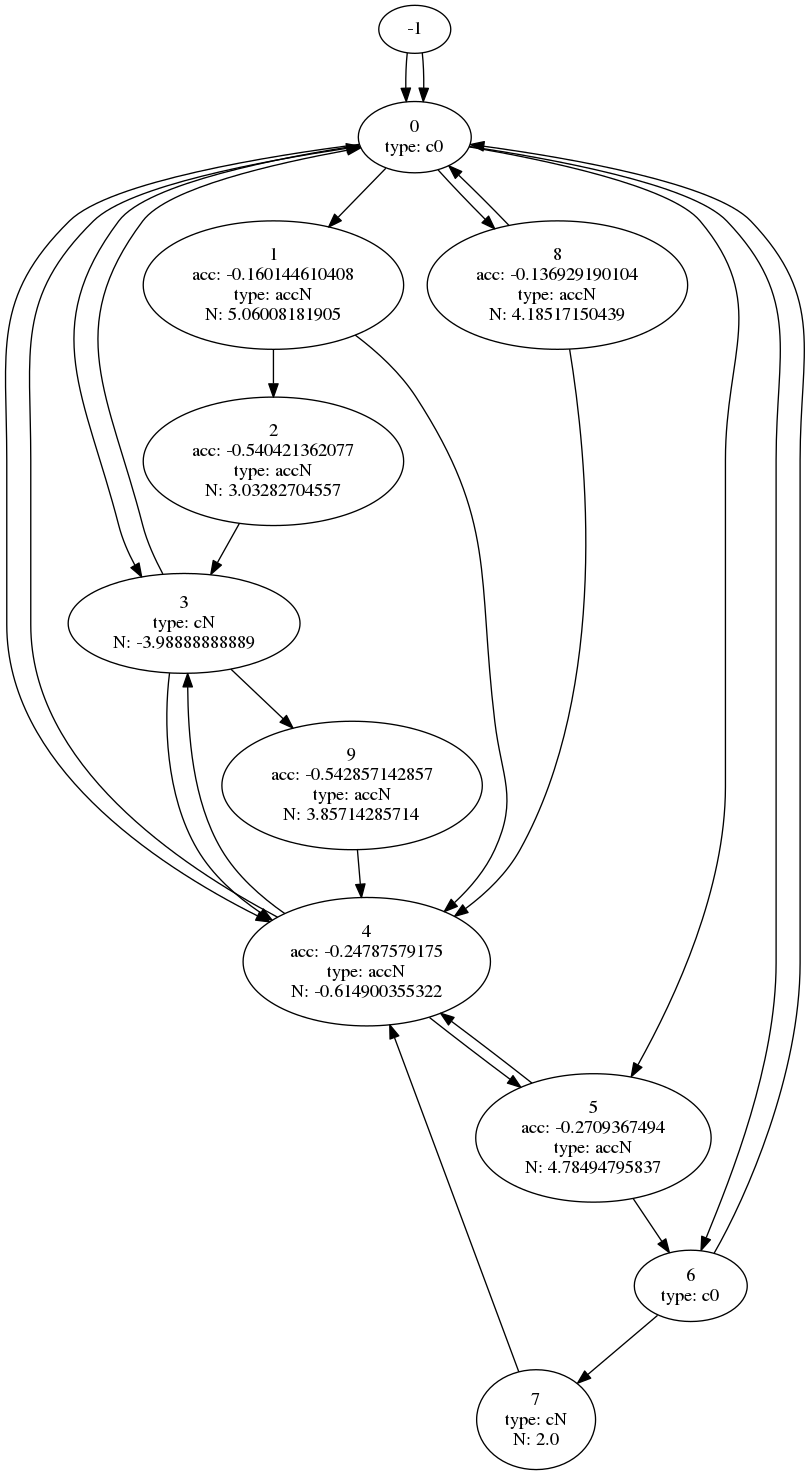

In [87]:
G = nx.MultiDiGraph()
to_add = {}

counts = {}
for tgt,srcs in entries_from.items():
    if tgt not in counts:
        counts[tgt] = 0
        
    for src,times in srcs.items():
        counts[tgt] += len(times)
print counts
for tgt,srcs in entries_from.items():
    if counts[tgt] > 0:
        G.add_node(tgt,label=str(tgt))
        # Let's learn about tgt
        mparams, mtype = modes[tgt]
        
        
        params = {"type": mtype}
        if mtype == 'c0':
            pass
        elif mtype == 'cP':
            pass
        elif mtype == 'cN':
            params["N"] = mparams[0]
        elif mtype == 'acc0':
            params["acc"] = mparams[0]
        elif mtype == 'accP':
            params["acc"] = mparams[0]
        elif mtype == 'accN':
            params["N"] = mparams[0]
            params["acc"] = mparams[1]
        for k,v in params.items():
            G.node[tgt]["label"] = (G.node[tgt]["label"] + "\n" + "{}: {}".format(k,v))
        print tgt,params
        for src,times in srcs.items():
            for t in times:
                if (src,tgt) not in to_add:
                    to_add[(src,tgt)] = []
                to_add[(src,tgt)].append('{}'.format(t))
                #G.add_edge(src,tgt,label=str(t))
for e in sorted(to_add):
    print e[0],e[1],':',' '.join(to_add[e]),':',len(to_add[e])
    G.add_edge(e[0],e[1])

G.add_node(-1)
G.add_edge(-1, 0)



nxpd.draw(G, show='ipynb')

In [88]:

def button_changes(button_masks):
    last_mask = 0
    mask_times = {}
    for t, b in enumerate(button_masks):
        b_ = int(b)
        buttons = []
        for ii,c in enumerate(list('RLDUTSBA')):
            if b_ & (1 << (7-ii)):
                buttons.append(c)
        l_ = int(last_mask)
        last_buttons = []
        for ii,c in enumerate(list('RLDUTSBA')):
            if l_ & (1 << (7-ii)):
                last_buttons.append(c)
        mask_times[t] = (tuple(last_buttons),tuple(buttons))
        last_mask = b
    
    return mask_times


button_change_times1 = button_changes(input1)
button_change_times2 = button_changes(input2)

In [89]:
def sign(num):
    if num < 0:
        return -1
    if num > 0:
        return 1
    return 0

def button_preds(button_pairs,input_id):
    here_i = set()
    for i,bp in button_pairs.items():
        bp0 = set(bp[0])
        bp1 = set(bp[1])
        released_i = bp0 - bp1
        pressed_i = bp1 - bp0
        held_i = bp1
        for ri in released_i:
            here_i.add(("release",ri,input_id))
        for ri in pressed_i:
            here_i.add(("press",ri,input_id))
        for ri in held_i:
            here_i.add(("hold",ri,input_id))
    return list(here_i)

def collision_preds(coll_pairs):
    here_i = set()
    for i,bp in coll_pairs.items():
        bp0 = set(bp[0])
        bp1 = set(bp[1])
        released_i = bp0 - bp1
        pressed_i = bp1 - bp0
        
        
        held_i = bp[1]
        #for ri in released_i:
        #    here_i.add(("col_stop",ri))
        for ri in pressed_i:
            here_i.add(("col_start",ri))
        #for ri in held_i:
        #    here_i.add(("col",ri))
    return list(here_i)

In [91]:
base_preds = [set()]*last_time
first_tc_time = sorted(tile_collisions)[0]
last_tc_time = sorted(tile_collisions)[-1]
for t in range(0,last_time):
    
    # TODO: button lag variables
    psi = ({i: button_change_times1.get(start_time+t+i,((),()))
            for i in range(-2, 1)},
            {i: button_change_times2.get(start_time+t+i,((),()))
            for i in range(-2, 1)},
           # TODO: collision lag variables?
            {i:(tile_collisions.get(start_time+t+(i-1),tile_collisions[first_tc_time]),
                 tile_collisions.get(start_time+t+(i),tile_collisions[last_tc_time]))
             for i in range(-2, 1)},
            {i:(sprite_collisions.get(start_time+t+(i-1),set()),
                 sprite_collisions.get(start_time+t+(i),set()))
             for i in range(-2, 1)},
            (velocities[t-1],velocities[t-0])
          )
    buttons1_i = psi[0]
    buttons2_i = psi[1]
    t_collisions_i = psi[2]
    s_collisions_i = psi[3]
    print t
    for c in collision_preds(s_collisions_i):
        print c
    here_i = button_preds(buttons1_i,1) + button_preds(buttons2_i,2) +collision_preds(t_collisions_i) +collision_preds(s_collisions_i)
   
    vel0,vel1 = psi[4]
    if vel1 == 0:
        here_i.append(("vel",0))
    #cur_mode = X
    # TODO: touched global min/max of velocity for current mode
    #mode_max = max(velocities_in_cur_mode)
    #mode_min = min(velocities_in_cur_mode)
    #if vel1 == mode_max and vel0 != mode_max:
    #  touched max
    #if vel1 == mode_min and vel0 != mode_min:
    #  touched min
    #if vel1 == mode_max:
    #  in min
    #if vel1 == mode_min:
    #  in max
    base_preds[t] = set(here_i)

for t,p in enumerate(base_preds):
    print t,p

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
('col_start', (2, ((12, (0.0, 0.0)), (13, (0.0, -8.0)), (15, (-8.0, 0.0)), (17, (-8.0, -8.0)))))
91
('col_start', (2, ((12, (0.0, 0.0)), (13, (0.0, -8.0)), (15, (-8.0, 0.0)), (17, (-8.0, -8.0)))))
92
('col_start', (2, ((12, (0.0, 0.0)), (13, (0.0, -8.0)), (15, (-8.0, 0.0)), (17, (-8.0, -8.0)))))
93
94
95
('col_start', (1, ((12, (0.0, 0.0)), (13, (0.0, -8.0)), (15, (-8.0, 0.0)), (17, (-8.0, -8.0)))))
96
('col_start', (1, ((12, (0.0, 0.0)), (13, (0.0, -8.0)), (15, (-8.0, 0.0)), (17, (-8.0, -8.0)))))
97
('col_start', (1, ((12, (0.0, 0.0)), (13, (0.0, -8.0)), (15, (-8.0, 0.0)), (17, (-8.0, -8.0)))))
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
('col_start', (1, ((12, (0.0, 0.0)),

In [9]:
def intervals_any_contains(intervals, t):
    if intervals is None:
        return True
    for (s,e) in intervals:
        if s <= t <= e:
            return True
    return False

def intervals_summed_length(intervals):
    return sum([(e-s)+1 for (s,e) in intervals])

def count_events(preds,intervals):
    all_counts = {}
    counts_by_time = {}
    for t,ps in enumerate(preds):
        if not intervals_any_contains(intervals, t): continue
        counts_by_time[t] = {}
        for p in ps:
            if p[0] in ["press","release","hold"] or "col" in p[0]:
                all_counts[p] = all_counts.get(p,0)+1./3.
                counts_by_time[t][p] = counts_by_time[t].get(p,0)+1./3.
            else:
                all_counts[p] = all_counts.get(p,0)+1
                counts_by_time[t][p] = counts_by_time[t].get(p,0)+1
        if t in transitions:
            tr = transitions[t]
            key = ("tr",tr)
            all_counts[key] = all_counts.get(key,0)+1
            counts_by_time[t][key] = counts_by_time[t].get(key,0)+1
            (_,dest) = tr
            keystar = ("tr",("*",dest))
            all_counts[keystar] = all_counts.get(keystar,0)+1
            counts_by_time[t][keystar] = counts_by_time[t].get(keystar,0)+1
    return all_counts, counts_by_time

def count_coevents(preds,intervals):
    all_counts = {}
    counts_by_time = {}
    for t,ps in enumerate(preds):
        if not intervals_any_contains(intervals, t): continue
        counts_by_time[t] = {}
        for p1 in ps:
            for p2 in ps:
                p = (p1,p2)
                
                if p1[0] in ["press","release","hold"] or p2[0] in ["press","release","hold"] :
                    all_counts[p] = all_counts.get(p,0)+1./3.
                    counts_by_time[t][p] = counts_by_time[t].get(p,0)+1./3.
                else:
                    all_counts[p] = all_counts.get(p,0)+1
                    counts_by_time[t][p] = counts_by_time[t].get(p,0)+1
                #all_counts[p] = all_counts.get(p,0)+1
                #counts_by_time[t][p] = counts_by_time[t].get(p,0)+1
        if t in transitions:
            for p1 in ps:
                tr = transitions[t]
                key = (("tr",tr),p1)
                if p1[0] in ["press","release","hold"] or "col" in p1[0]:
                    all_counts[key] = all_counts.get(key,0)+1./3.
                    counts_by_time[t][key] = counts_by_time[t].get(key,0)+1./3.
                    (_,dest) = tr
                    keystar = (("tr",("*",dest)),p1)
                    all_counts[keystar] = all_counts.get(keystar,0)+1./3.
                    counts_by_time[t][keystar] = counts_by_time[t].get(keystar,0)+2./3.
                else:
                    all_counts[key] = all_counts.get(key,0)+1
                    counts_by_time[t][key] = counts_by_time[t].get(key,0)+1
                    (_,dest) = tr
                    keystar = (("tr",("*",dest)),p1)
                    all_counts[keystar] = all_counts.get(keystar,0)+1
                    counts_by_time[t][keystar] = counts_by_time[t].get(keystar,0)+1
    return all_counts, counts_by_time

In [10]:
all_counts, counts_by_time = count_events(base_preds,None)
all_cocounts, cocounts_by_time = count_coevents(base_preds,None)

In [11]:
# Let's figure out which tiles block movement on which sides!
# co-occurrence of (col, BLAH) and acc0 for each BLAH.
# cluster together tiles which block on a given side (for now, all those with co-occurrence over threshold)
# then add new preds!

def cond_prob(e1s, e2, all_counts, counts_by_time):
    p2 = all_counts[e2]/float(len(counts_by_time))
    count12 = 0
    for t,cs in counts_by_time.items():
        any_e1_present = False
        for e1 in e1s:
            if e1 in cs:
                any_e1_present = True
                break
        if any_e1_present and (e2 in cs):
            count12 += 1
    p12 = count12 / float(len(counts_by_time))
    return p12 / p2

block_chance = {}
for thing,count in all_counts.items():
    # TODO: note "colliding on right with something" -> "vely=0" is not that sensible.
    #  need a notion of acc,vel,zin,zout and _other axis_ acc,vel,zin,zout.
    if thing[0] != "col" or thing[-1] != 0:
        continue
    block_chance[thing[1]] = cond_prob([("vel",0),("acc",0)], 
                                        ("col", thing[1], 0),
                                        all_counts,
                                        counts_by_time)

block_chance_unify_threshold = 0.8

merged_by_side = {}
for side in ["bottom","right","left","top"]:
    # Let's pretend colliding with sprites is the same as colliding with tiles?  Maybe needed for moving platforms?
    blockings = filter(lambda (col,prob):(col[1] == side and 
                                          prob > block_chance_unify_threshold),
                       block_chance.items())
    merged_by_side[side] = set()
    for bcol,bprob in blockings:
        merged_by_side[side].add(bcol)
    merged_by_side[side] = sets.ImmutableSet(merged_by_side[side])
        
    
#color_tiles = pickle.load(open('tile2colorized.pkl'))
for side,bcols in merged_by_side.items():
    print "----\n{}\n----".format(side)
    for bc in bcols:
        print block_chance[bc],bc[0]

----
top
----
----
right
----
----
left
----
----
bottom
----


In [12]:
# Let's add new preds now!
extended_preds = [set() for i in range(0,len(base_preds))]
for t,pset in enumerate(base_preds):
    for side,equiv in merged_by_side.items():
        for pred in pset:
            extended_preds[t].add(pred)
            if pred[0] == "col" and pred[1] in equiv:
                extended_preds[t].add(("col", (("solid", equiv), side), pred[2]))
            if pred[0] == "col_start" and pred[1] in equiv:
                extended_preds[t].add(("col_start", (("solid", equiv), side), pred[2]))
            if pred[0] == "col_stop" and pred[1] in equiv:
                extended_preds[t].add(("col_stop", (("solid", equiv), side), pred[2]))

# HACK: Drop distinctions between lag variables for now.  They were important before!
for t,pset in enumerate(extended_preds):
    extended_preds[t] = set(map(lambda p:(p[0], p[1], 0) if (p[0] == "col" or p[0] == "col_start" or 
                                                             p[0] == "col_stop" or p[0] == "press" or 
                                                             p[0] == "release" or p[0] == "hold") else p,
                                pset))

all_counts,counts_by_time = count_events(extended_preds,None)
all_cocounts,cocounts_by_time = count_coevents(extended_preds,None)


In [13]:
#TODO: update to support intervals?

def count_conditional_events(preds,condition):
    all_counts = {}
    counts_by_time = {}
    for t,ps in enumerate(preds):
        counts_by_time[t] = {}
        if condition in ps:
            for p in ps:
                all_counts[p] = all_counts.get(p,0)+1
                counts_by_time[t][p] = counts_by_time[t].get(p,0)+1
            if t in transitions:
                tr = transitions[t]
                key = ("tr",tr)
                all_counts[key] = all_counts.get(key,0)+1
                counts_by_time[t][key] = counts_by_time[t].get(key,0)+1
                (_,dest) = tr
                keystar = ("tr",("*",dest))
                all_counts[keystar] = all_counts.get(keystar,0)+1
                counts_by_time[t][keystar] = counts_by_time[t].get(keystar,0)+1
    return all_counts

def count_joint_events(preds,conditions):
    count = 0
    for t,ps in enumerate(preds):
        trans = transitions.get(t,-1)
        is_good = True
        for condition in conditions:
            if condition not in ps and condition != trans:
                is_good = False
                break
        if is_good:
            count += 1
    return count
    
def count_conditional_coevents(preds,condition):
    all_counts = {}
    counts_by_time = {}
    for t,ps in enumerate(preds):
        counts_by_time[t] = {}
        if condition in ps:
            for p1 in ps:
                for p2 in ps:
                    p = (p1,p2)
                    all_counts[p] = all_counts.get(p,0)+1
                    counts_by_time[t][p] = counts_by_time[t].get(p,0)+1
            if t in transitions:
                for p1 in ps:
                    tr = transitions[t]
                    key = (("tr",tr),p1)
                    all_counts[key] = all_counts.get(key,0)+1
                    counts_by_time[t][key] = counts_by_time[t].get(key,0)+1
                    (_,dest) = tr
                    keystar = (("tr",("*",dest)),p1)
                    all_counts[keystar] = all_counts.get(keystar,0)+1
                    counts_by_time[t][keystar] = counts_by_time[t].get(keystar,0)+1
    return all_counts

In [14]:
mode_periods = {}

for t in range(0,len(merged_trace)):
    cur = merged_trace[t][2]
    start = merged_trace[t][0]
    end = merged_trace[t][1]
    if cur not in mode_periods:
        mode_periods[cur] = []
    mode_periods[cur].append((start,end))

transition_leadin_intervals = {}

for src in modes:
    for tgt in modes:
        if src == tgt: continue
        intervals = [(s,e)
                      for (s,e) in mode_periods[src] 
                      if e in transitions and transitions[e][1] == tgt]
        transition_leadin_intervals[(src,tgt)] = intervals

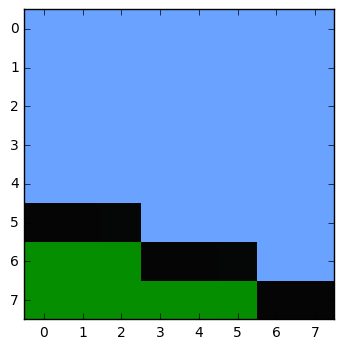

(0, 1) ('col_start', (3, 36), 0) 0.406768720472


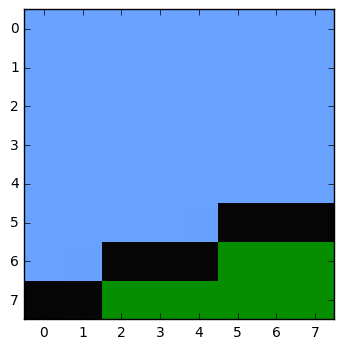

(0, 1) ('col_start', (1, 35), 0) 0.406768720472
(0, 1) ('hold', 'A', 0) 0.542406918335
(0, 1) ('press', 'A', 0) 0.733598925199



(0, 5) ('hold', 'A', 0) 0.737779756015
(0, 5) ('press', 'A', 0) 0.737779756015


(0, 8) ('press', 'A', 0) 0.727070253853

(1, 2) ('release', 'A', 0) 0.700124525043

(1, 4) ('release', 'A', 0) 0.41792127266
(1, 4) ('vel', 0) 0.910992791465




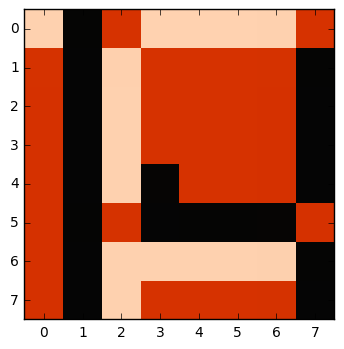

(3, 0) ('col_start', (1, 6), 0) 0.657732438393


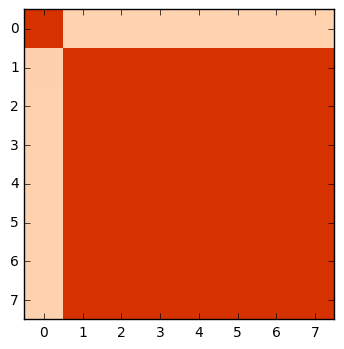

(3, 0) ('col_start', (1, 4), 0) 0.657732438393
(3, 0) ('vel', 0) 0.876976584524



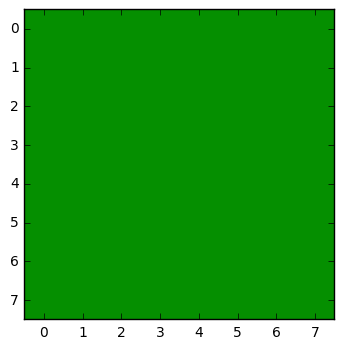

(3, 4) ('col_start', (1, 2), 0) 0.429636739879


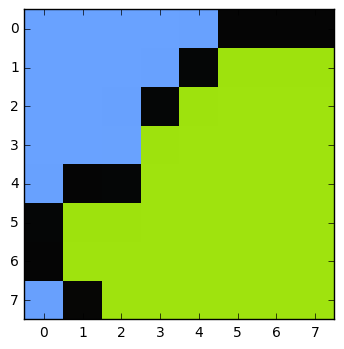

(3, 4) ('col_start', (1, 17), 0) 0.588735547748


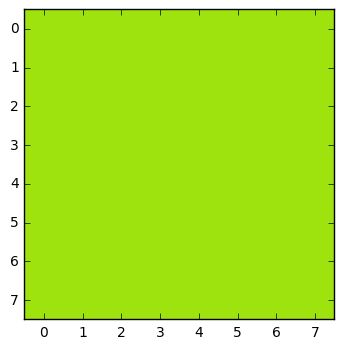

(3, 4) ('col_start', (1, 19), 0) 0.588735547748


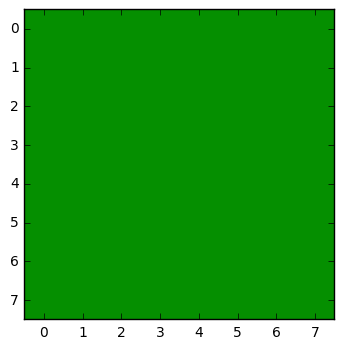

(3, 4) ('col_start', (2, 2), 0) 0.588735547748


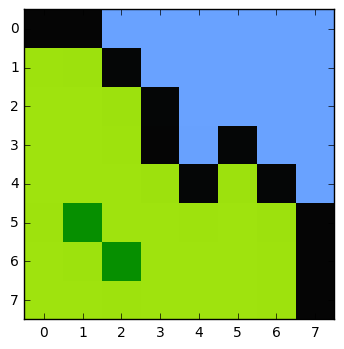

(3, 4) ('col_start', (2, 20), 0) 0.588735547748

(3, 9) ('col_start', (1, ((12, (0.0, 0.0)), (13, (0.0, -8.0)), (15, (-8.0, 0.0)), (17, (-8.0, -8.0)))), 0) 0.432417854008


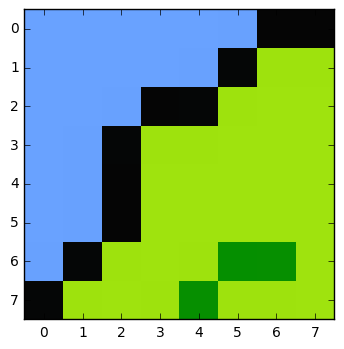

(3, 9) ('col_start', (2, 18), 0) 0.537156695253


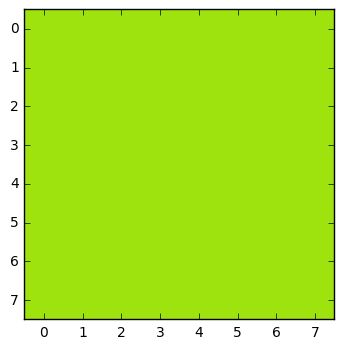

(3, 9) ('col_start', (1, 19), 0) 0.537156695253
(3, 9) ('col_start', (3, ((23, (0.0, 0.0)), (24, (-8.0, 0.0)))), 0) 0.716208927004



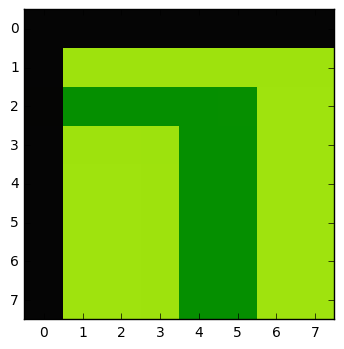

(4, 0) ('col_start', (1, 43), 0) 0.445406674875


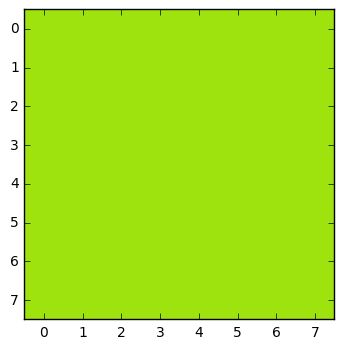

(4, 0) ('col_start', (2, 19), 0) 0.445406674875


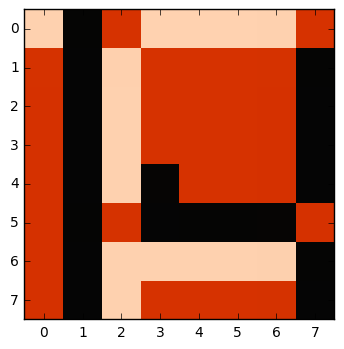

(4, 0) ('col_start', (2, 6), 0) 0.504216738751


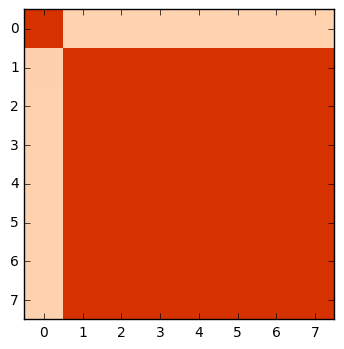

(4, 0) ('col_start', (1, 4), 0) 0.602716310108


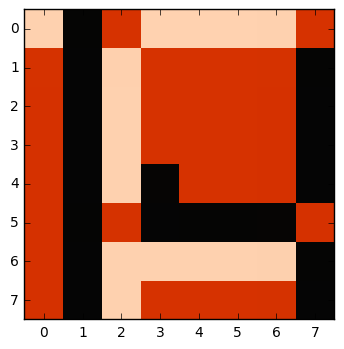

(4, 0) ('col_start', (1, 6), 0) 0.602716310108
(4, 0) ('vel', 0) 0.662323182538


(4, 5) ('hold', 'A', 0) 0.619906233284
(4, 5) ('press', 'A', 0) 0.619906233284

(5, 4) ('release', 'A', 0) 0.685797250727
(5, 4) ('col_start', (1, ((27, (-8.0, 0.0)), (28, (-8.0, -8.0)))), 0) 0.685797250727
(5, 4) ('vel', 0) 1.0



(6, 7) ('col_start', (1, ((23, (0.0, 0.0)), (24, (-8.0, 0.0)))), 0) 0.487557387556


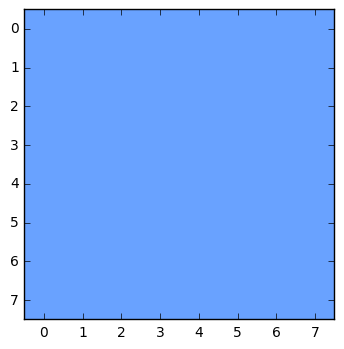

(6, 7) ('col_start', (1, 0), 0) 0.487557387556

(7, 4) ('hold', 'R', 0) 0.594316128918
(7, 4) ('press', 'R', 0) 0.594316128918

(8, 0) ('col_start', (1, ((33, (0.0, 0.0)), (34, (-8.0, 0.0)), (35, (0.0, -8.0)), (36, (-8.0, -8.0)))), 0) 0.403946263919
(8, 0) ('vel', 0) 0.489108803105


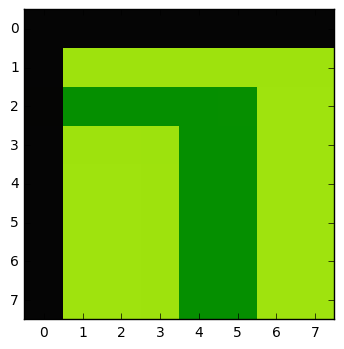

(8, 0) ('col_start', (1, 43), 0) 0.602630842613

(8, 4) ('col_start', (1, ((78, (0.0, 0.0)),)), 0) 0.541048905066


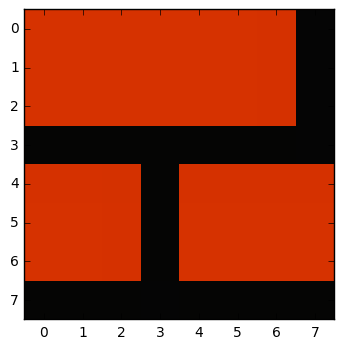

(8, 4) ('col_start', (1, 38), 0) 0.541048905066
(8, 4) ('col_start', (3, ((78, (0.0, 0.0)),)), 0) 0.541048905066
(8, 4) ('col_start', (1, ((29, (0.0, 0.0)), (30, (-8.0, 0.0)), (31, (0.0, -8.0)), (32, (-8.0, -8.0)))), 0) 0.541048905066
(8, 4) ('vel', 0) 0.864652421818




In [15]:
inv_len = 1.0/float(len(track))
npmis = {}
pmis = {}
id2image = pickle.load(open('id2image.pkl'))
for m1 in modes:
    for m2 in modes:
        if m1 == m2: continue
        transition = (m1,m2)
        intervals = transition_leadin_intervals[transition]
        intvl_len = intervals_summed_length(intervals)
        if intvl_len == 0: continue
        tr_counts,_by_time = count_events(extended_preds, intervals)
        tr_cocounts,_by_time = count_coevents(extended_preds, intervals)
        tr_inv_len = 1.0/float(intvl_len)
        for pred in tr_counts:
            if pred != transition:
                p1 = tr_counts[pred]*tr_inv_len
                p2 = tr_counts[("tr",transition)]*tr_inv_len
                cooccur = (("tr",transition),pred)
                
                if cooccur in tr_cocounts:
                    p12 = tr_cocounts[cooccur]*tr_inv_len
                else:
                    p12 = 0.0
                if transition not in npmis:
                    npmis[transition] = {}
                if p12/(p1*p2) != 0.0:
                    pmi = np.log(p12/(p1*p2))
                    npmi = pmi/-np.log(p12)
                        
                    pmis[(transition,pred)] = pmi
                    npmis[transition][pred] = npmi
                else:
                    npmis[transition][pred] = -1.0

for t in sorted(npmis):
    for e1,pmi in reversed(sorted(npmis[t].items(), lambda a,b:sign(b[1] - a[1]))):
        if pmi > 0.4:
            if e1[0] == 'col_start':
                if e1[1][1] in id2image:
                    tile = id2image[e1[1][1]]
                    plt.imshow(tile[:,:,:3]/255.,interpolation='none')
                    plt.show()
            print t, e1, pmi
    print ''

In [61]:
edges = {}
for t in sorted(npmis):
    for e1,pmi in reversed(sorted(npmis[t].items(), lambda a,b:sign(b[1] - a[1]))):
        if pmi > 0.4:
            from_mode = t[0]
            to_mode = t[1]
            if from_mode not in edges:
                edges[from_mode] = {}
            if e1 not in edges[from_mode]:
                edges[from_mode][e1] = []
            edges[from_mode][e1].append(to_mode)   
for from_mode in edges:
    print from_mode
    for cause in edges[from_mode]:
        print '\t',cause , '->'
        for to_mode in edges[from_mode][cause]:
            print '\t\t',to_mode
            if len(edges[from_mode][cause]) > 1:
                print '\t\t',entries_from[to_mode][from_mode]
                for time in entries_from[to_mode][from_mode]:
                    print np.abs(filtered_x[time]), y_velocities[time]

0
	('hold', 'A', 0) ->
		1
		[46, 486, 531, 648, 859]
1.5921928074 5.0
1.99556813838 5.0
2.49280661455 5.0
1.6996055653 5.0
2.50719338545 5.0
		5
		[164]
0.99556813838 4.0
	('col_start', (1, 35), 0) ->
		1
	('press', 'A', 0) ->
		1
		[46, 486, 531, 648, 859]
1.5921928074 5.0
1.99556813838 5.0
2.49280661455 5.0
1.6996055653 5.0
2.50719338545 5.0
		5
		[164]
0.99556813838 4.0
		8
		[210, 331, 442, 599, 754, 929]
0.0 4.0
0.0 4.0
0.488508583558 4.0
0.00456569224465 4.0
0.0 4.0
2.10811608547 5.0
	('col_start', (3, 36), 0) ->
		1
1
	('vel', 0) ->
		4
	('release', 'A', 0) ->
		2
		[61, 495]
1.00013383062 3.0
2.48837475293 3.0
		4
		[555, 678, 878]
2.49280661455 0.0
2.49280661455 0.0
2.49280661455 0.0
3
	('col_start', (1, 17), 0) ->
		4
	('vel', 0) ->
		0
	('col_start', (3, ((23, (0.0, 0.0)), (24, (-8.0, 0.0)))), 0) ->
		9
	('col_start', (2, 2), 0) ->
		4
	('col_start', (1, 4), 0) ->
		0
	('col_start', (1, 19), 0) ->
		4
		[86, 899]
0.00443186162003 -2.0
2.50719338545 -4.0
		9
		[578]
2.507193

[ 7.81663481]
[ 7.1882739]
[ 8.63690248]
[ 8.9698133]


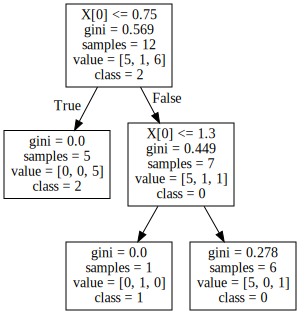

In [116]:
from sklearn import tree
import graphviz 
X = [[1.6],
     [2.],
     [2.5],
     [1.7],
     [2.5],
     [1.],
     [0.],
     [0.],
     [0.5],
     [0.],
     [0.],
     [2.1]]
Y = [[0],
     [0],
     [0],
     [0],
     [0],
     [1],
     [2],
     [2],
     [2],
     [2],
     [2],
     [2]]



def get_likelihood(classifier,X,Y):
    pY = clf.predict_proba(X)
    summed = 0
    for y,p in zip(Y,pY):
        summed += -np.log(p[y])
    return summed
        
def get_structure(estimator):
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    count = 0
    for i in range(n_nodes):
        if not is_leaves[i]:
            count += 1
    return count
best_value = float('inf')
best_graph = None


for d in range(1,5):
    clf = tree.DecisionTreeClassifier(max_depth=d,splitter='best')
    clf = clf.fit(X, Y)


    score = get_likelihood(clf,X,Y)+(1+np.log(len(Y))*0.5)*get_structure(clf)
    print score
    if score < best_value:
        best_value = score
        best_graph = tree.export_graphviz(clf, out_file=None,  
                             class_names=["0","1","2"]  ) 

graph = graphviz.Source(best_graph) 

graph


1.97295507453
1.97295507453
1.97295507453
1.97295507453


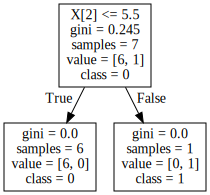

In [125]:

X = np.hstack((x_velocities[348:355].reshape(-1,1),np.abs(x_velocities[348:355]).reshape(-1,1),np.linspace(0,355-348-1,355-348).reshape(-1,1)))
Y = [0,0,0,0,0,0,1]

X = np.hstack((x_velocities[348:355].reshape(-1,1),np.abs(x_velocities[348:355]).reshape(-1,1),np.linspace(0,355-348-1,355-348).reshape(-1,1)))
Y = [0,0,0,0,0,0,1]


for d in range(1,5):
    clf = tree.DecisionTreeClassifier(max_depth=d,splitter='best')
    clf = clf.fit(X, Y)


    score = get_likelihood(clf,X,Y)+(1+np.log(len(Y))*0.5)*get_structure(clf)
    print score
    if score < best_value:
        best_value = score
        best_graph = tree.export_graphviz(clf, out_file=None,  
                             class_names=["0","1","2"]  ) 

graph = graphviz.Source(best_graph) 

graph

In [81]:
print len(base_preds)
for d in range(1,5):
    clf = tree.DecisionTreeClassifier(max_depth=d,splitter='best')
    clf = clf.fit(X, Y)


    score = get_likelihood(clf,X,Y)+(1+np.log(len(Y))*0.5)*get_structure(clf)
    print score
    if score < best_value:
        best_value = score
        best_graph = tree.export_graphviz(clf, out_file=None,  
                             class_names=["0","1","2"]  ) 

graph = graphviz.Source(best_graph) 

graph

999


In [82]:
print last_time

984
